# Exercise 6 | Robust MPC



## Problem 1 | Robust Invariant Set

Design a robust MPC controller for the following linear system:

$$x^+ = Ax + Bu + w,  A=\begin{bmatrix}1 & 1 \\ 0 & 1\end{bmatrix}, B=\begin{bmatrix}1 \\ 0.5\end{bmatrix} $$

with constraints and bounded disturbance

$$\mathcal{X} = \{x \mid \|x\|_{\infty} \leq 3 \}, \quad \mathcal{U} = \{u \mid ~\|u\|_{\infty} \leq 0.5 \} \quad \mathcal{W} = \{w \mid \|w\|_{\infty} \leq 0.1 \} $$

The matrix $K$ is the LQR gain with $Q=I$ and $R=10$.



In [38]:
import numpy as np
from mpt4py import Polyhedron
from control import dlqr

A = np.array([[1, 1], [0, 1]])
B = np.array([[1], [0.5]])
Q = np.eye(2)
R = 10 * np.eye(1)

K, Qf, _ = dlqr(A, B, Q, R)
K = -K
A_cl = A + B @ K

x_max = 3.
u_max = 0.5
w_max = 0.1

X = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=x_max*np.ones(4))
U = Polyhedron.from_Hrep(A=np.vstack((np.eye(1), -np.eye(1))), b=u_max*np.ones(2))
W = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=w_max*np.ones(4))


### Task 1
Implement a function to compute the robust pre-set operator $\text{pre}^{\mathcal{W}}(\cdot)$


In [39]:
def robust_pre_set(A_cl: np.ndarray, Omega: Polyhedron, W: Polyhedron) -> Polyhedron:
	"""
	Compute the robust pre-set of the polytopic set Omega under the 
	autonomous LTI system x^+ = A_cl * x and polytopic disturbance set W.
	"""
	b_pre=Omega.b.copy()

	for i in range(Omega.b.shape[0]):
		b_pre [i]-=W.support(Omega.A[i,:])
	pre_Omega = Polyhedron.from_Hrep(Omega.A @ A_cl, b_pre)
	return pre_Omega

### Task 2
Implement a function to compute the maximal robust invariant set $\mathcal{X}_f^{\mathcal{W}}$ for the above system. Use it to compute the maximal robust invariant set for the system mentioned above.

Also compute the nominal maximal invariant set $\mathcal{X}_f$ using your code from previous exercises. 

Which set do you expect to be larger? Plot both sets and compare.

**Hints**: The algorithm to compute maximal robust invariant set is summarized in the following steps. This is indeed the same algorithm as computing maximal invariant set for nominal MPC. The only difference is the pre-set operator $\text{pre}(\Omega_i)$ is replaced by the robust pre set operator $\text{pre}^\mathcal{W}(\Omega_i)$. 

$$
\begin{array}{l}
	\Omega_0 \gets \mathcal{X} \\
	\textbf{loop} \\
	\quad \Omega_{i+1} \gets \text{pre}^\mathcal{W}(\Omega_i) \cap \Omega_i \\
	\quad \textbf{if} ~ \Omega_{i+1} == \textbf{pre}^\mathcal{W} (\Omega_i) \\
	\quad\quad \textbf{return} ~ \Omega_{\infty}^\mathcal{W} = \Omega_{i} \\
	\quad \textbf{end if} \\
	\textbf{end loop}
\end{array}
$$


In [41]:
def max_robust_invariant_set(A_cl: np.ndarray, Omega: Polyhedron, W: Polyhedron, max_iter: int = 50) -> Polyhedron:
	"""
	Compute the maximal robust positive invariant set of the polytopic set Omega
	under the autonomous LTI system x^+ = A_cl * x.
	"""
	Opre=Omega
	
	i=1
	while i<=max_iter:
		Onew=(robust_pre_set(A_cl,Opre,W).intersect(Opre))
		if Onew==Opre :
			print(f"solution found for {i} iterations")
			return Onew
		elif i==max_iter:
			print(f"no solution found for {i} iterations")
			return Onew
		i+=1
		Opre=Onew
		

In [42]:
def pre_set(A_cl: np.ndarray, Omega: Polyhedron) -> Polyhedron:
	pre_Omega = Polyhedron.from_Hrep(A=Omega.A @ A_cl, b=Omega.b.copy())
	return pre_Omega

def max_invariant_set(A_cl, X: Polyhedron, max_iter = 30) -> Polyhedron:
	"""
	Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
	"""
	Opre=X
	i=1
	while i<=max_iter:
		Onew=pre_set(A_cl,Opre).intersect(Opre)
		if Onew==Opre :
			print(f"solution found for {i} iterations")
			return Onew
		elif i==max_iter:
			print(f"no solution found for {i} iterations")
			return Onew
		i+=1
		Opre=Onew


solution found for 3 iterations
solution found for 5 iterations


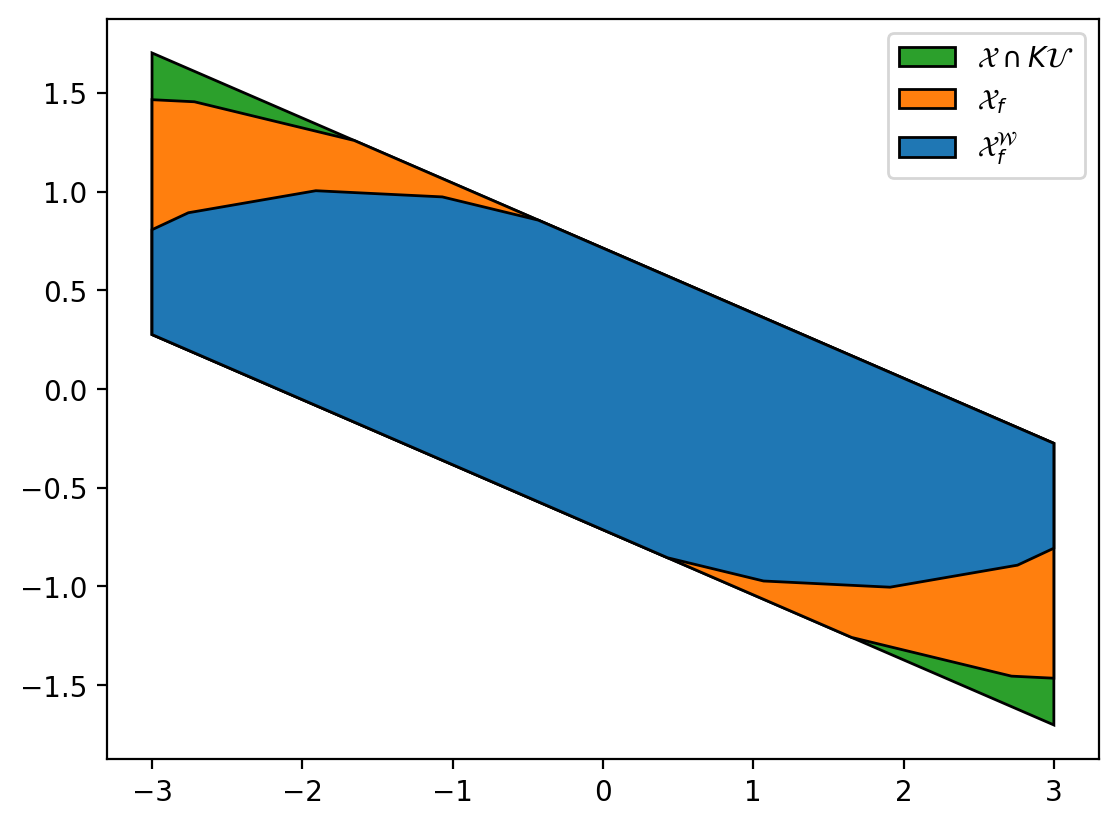

In [44]:
X_and_KU = X.intersect(Polyhedron.from_Hrep(U.A@K, U.b))
Xf = max_invariant_set(A_cl, X_and_KU)
Xf_W = max_robust_invariant_set(A_cl, X_and_KU, W)

# Plot the sets
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:orange', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
plt.legend()
plt.show()

### Task 3

Plot several trajectories under bounded disturbance $w_i\in\mathcal{W}$ starting from various $x_0\in\mathcal{X}_f^{\mathcal{W}} $. Show that the entire trajectory $\{x_i\}$ remains within $\mathcal{X}_f^{\mathcal{W}}$.

**Hints:** in *mpt4py*, you can uniformly sample $m$ points from a polyhedron $P\subset \mathbb{R}^n$ with `x_sampled = P.sample(m)`, where `x_sample` is a NumPy array with shape `(m, n)`.

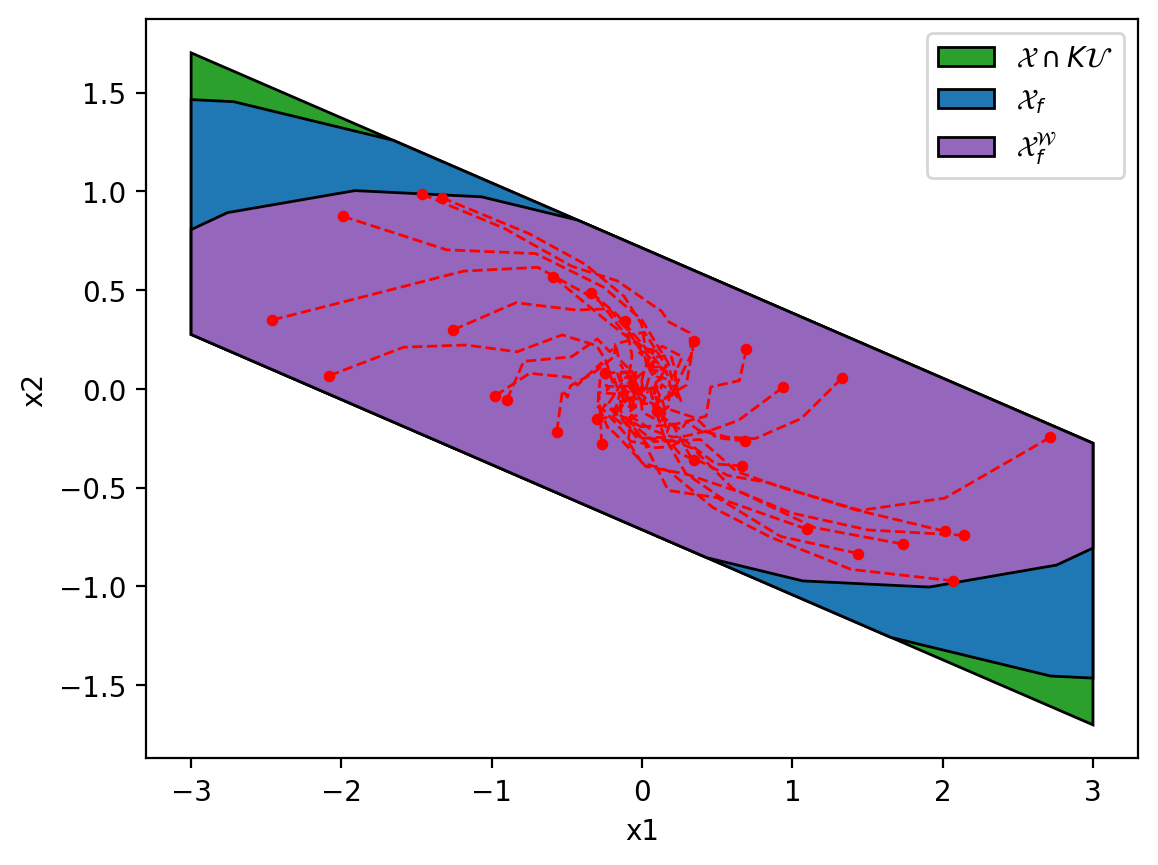

In [96]:
num_samples = 30
x0_samples = Xf_W.sample(num_samples)  # ndarray with shape (num_samples, 2)
N_sim = 10  # simulation steps

# Plot the sets
fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:purple', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
ax.set_xlabel('x1')
ax.set_ylabel('x2')


for x in x0_samples:
    traj=np.ndarray((x.shape[0],N_sim))
    traj[:,0]=x
    for a in range(1,N_sim):
        traj[:,a]=A_cl @ traj[:,a-1] +W.sample(1).reshape([-1])
    ax.plot(traj[0,:],traj[1,:],color='red',linestyle='--',linewidth=1)

ax.scatter(x0_samples[:,0],x0_samples[:,1],color='red',s=10.)
ax.legend()
plt.show()

### Task 4

Plot several trajectories under bounded disturbance $w_i\in\mathcal{W}$ starting from various $x_0 \in \mathcal{X}_f \setminus \mathcal{X}_f^{\mathcal{W}}$. Show that there exists an $x_i \notin \mathcal{X}$.

**Hints:** You can sample points $x_0\in \mathcal{X}_f \setminus \mathcal{X}_f^{\mathcal{W}}$ by sampling a number of points from $\mathcal{X}_f$ and remove those that aren't in the $\mathcal{X}_f^{\mathcal{W}}$.

In [97]:
num_samples = 30
N_sim = 10  # simulation steps

s=0
sample1=Xf.sample(1).reshape([-1])
samplef=np.zeros((num_samples,sample1.shape[0]))
while s<num_samples:
    if sample1 not in Xf_W:
        samplef[s,:]=sample1
        s+=1
    sample1=Xf.sample(1).reshape([-1])
    

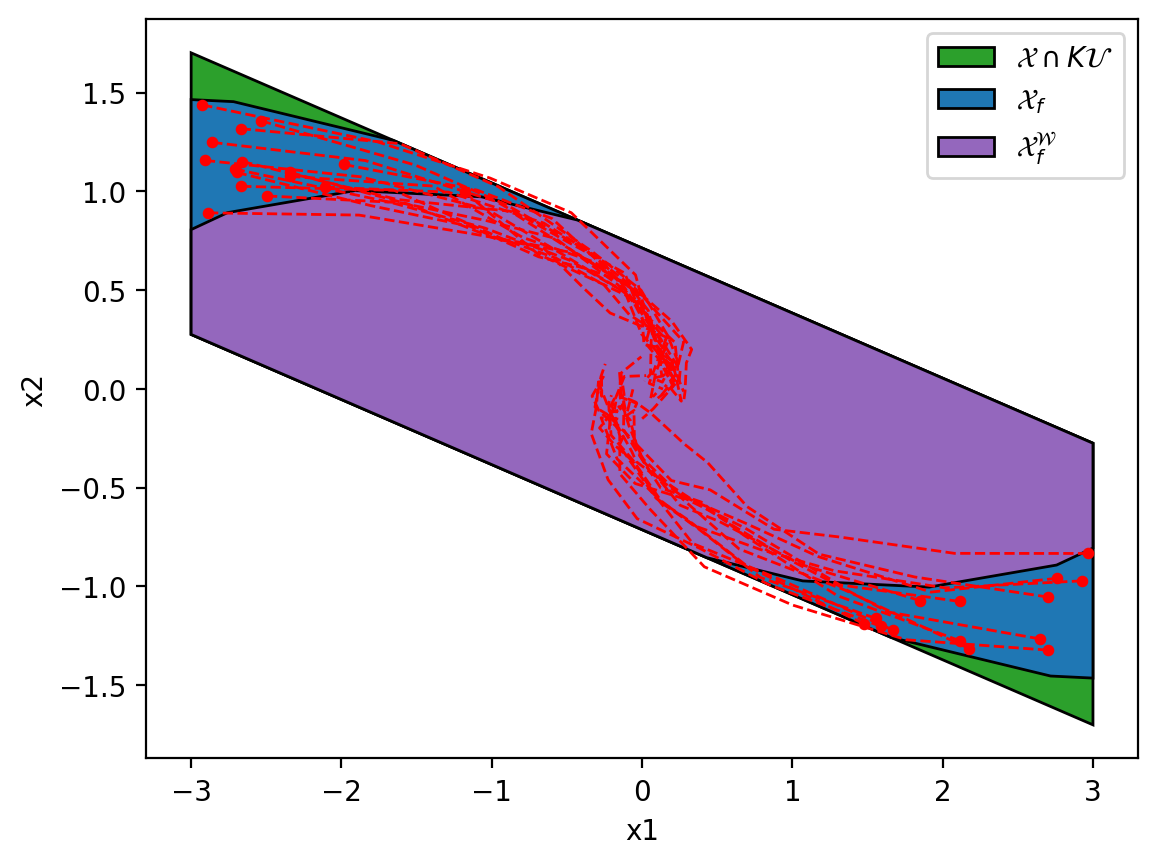

In [99]:
# Plot the sets
fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:purple', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

for x in samplef:
    traj=np.ndarray((x.shape[0],N_sim))
    traj[:,0]=x
    for a in range(1,N_sim):
        traj[:,a]=A_cl @ traj[:,a-1] +W.sample(1).reshape([-1])
    ax.plot(traj[0,:],traj[1,:],color='red',linestyle='--',linewidth=1)

ax.scatter(samplef[:,0],samplef[:,1],color='red',s=10.)
ax.legend()
plt.show()